In [3]:
import torch

import model

net = model.Time2Vec(
    input_size=9,
    activation="sin",
    hidden_dim=200,
    out_dim=1,
    batch_size=32,
    lstm_hidden_dim=20,
    lstm_layer=1
)

ckpt = torch.load("best.ckpt")
w = {k[4:]: v for k, v in ckpt["state_dict"].items() if k.startswith("net.")}

net.load_state_dict(w)
net.eval()

Time2Vec(
  (tsv): SineActivation()
  (lstm): LSTM(200, 20, batch_first=True)
  (out_layer): Linear(in_features=20, out_features=1, bias=True)
)

In [4]:

import pandas as pd
import datetime
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv("../train_model/data/bitcoin_2017_to_2023.csv")

df = df.dropna()
df = df.reset_index(drop=True)
df["timestamp"] = df["timestamp"].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

df = df.drop(columns=["timestamp"])
df = df.reset_index(drop=True)

df_len = len(df)
test_size = 0.2
cut_idx = int(df_len*test_size)
train, val = df.iloc[cut_idx:], df.iloc[:cut_idx]


In [5]:

scaler = MinMaxScaler(feature_range=(-1, 1))
train = train.copy()
train[train.columns] = scaler.fit_transform(train[train.columns])
val = val.copy()
val[val.columns] = scaler.transform(val[val.columns])


In [6]:
tsv = net.tsv

In [22]:
import pinecone

pinecone.init(api_key="9882a900-ced3-4f2c-a5a5-bea615c330f3", environment="asia-southeast1-gcp-free")
crypto_pinecone = pinecone.Index("crypto")

In [24]:
from tqdm import tqdm

window_size = 30
tsv_preds = []
tsv_labels = []
for index in tqdm(range(len(val) - window_size - 2)):
    x = val.iloc[index: index + window_size].values
    y = val.iloc[index + window_size][["close"]].values

    x = torch.Tensor(x).unsqueeze(dim=0)
    y = torch.Tensor(y).unsqueeze(dim=0)

    pred = tsv(x).flatten()
    upsert_response = crypto_pinecone.upsert(
        vectors=[(str(index), pred.tolist())]
    )
    
    # tsv_preds.append(pred.detach().numpy())
    # tsv_labels.append(y.numpy())

  0%|          | 41/625168 [00:13<55:55:04,  3.11it/s]


KeyboardInterrupt: 

In [8]:
import numpy as np

tsv_preds = np.array(tsv_preds).squeeze()
tsv_labels = np.array(tsv_labels).squeeze()

In [24]:
tsv_preds_df = pd.DataFrame(tsv_preds, columns=["close"])
tsv_labels_df = pd.DataFrame(tsv_labels, columns=["close"])

In [49]:
train_close = train["close"].values.reshape(-1, 1)
close_scaler = MinMaxScaler(feature_range=(-1, 1))
close_scaler.fit(train_close)

rescaled_tsv_preds = close_scaler.inverse_transform(tsv_preds_df).squeeze()
rescaled_tsv_labels = close_scaler.inverse_transform(tsv_labels_df).squeeze()

result = pd.DataFrame({
    "pred": rescaled_tsv_preds,
    "label": rescaled_tsv_labels
})

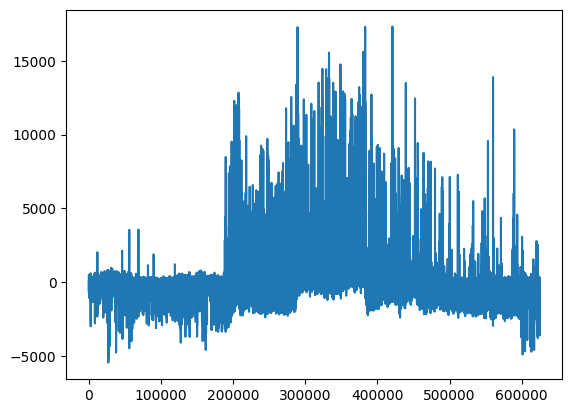

In [56]:
plt.plot(rescaled_tsv_preds - rescaled_tsv_labels)

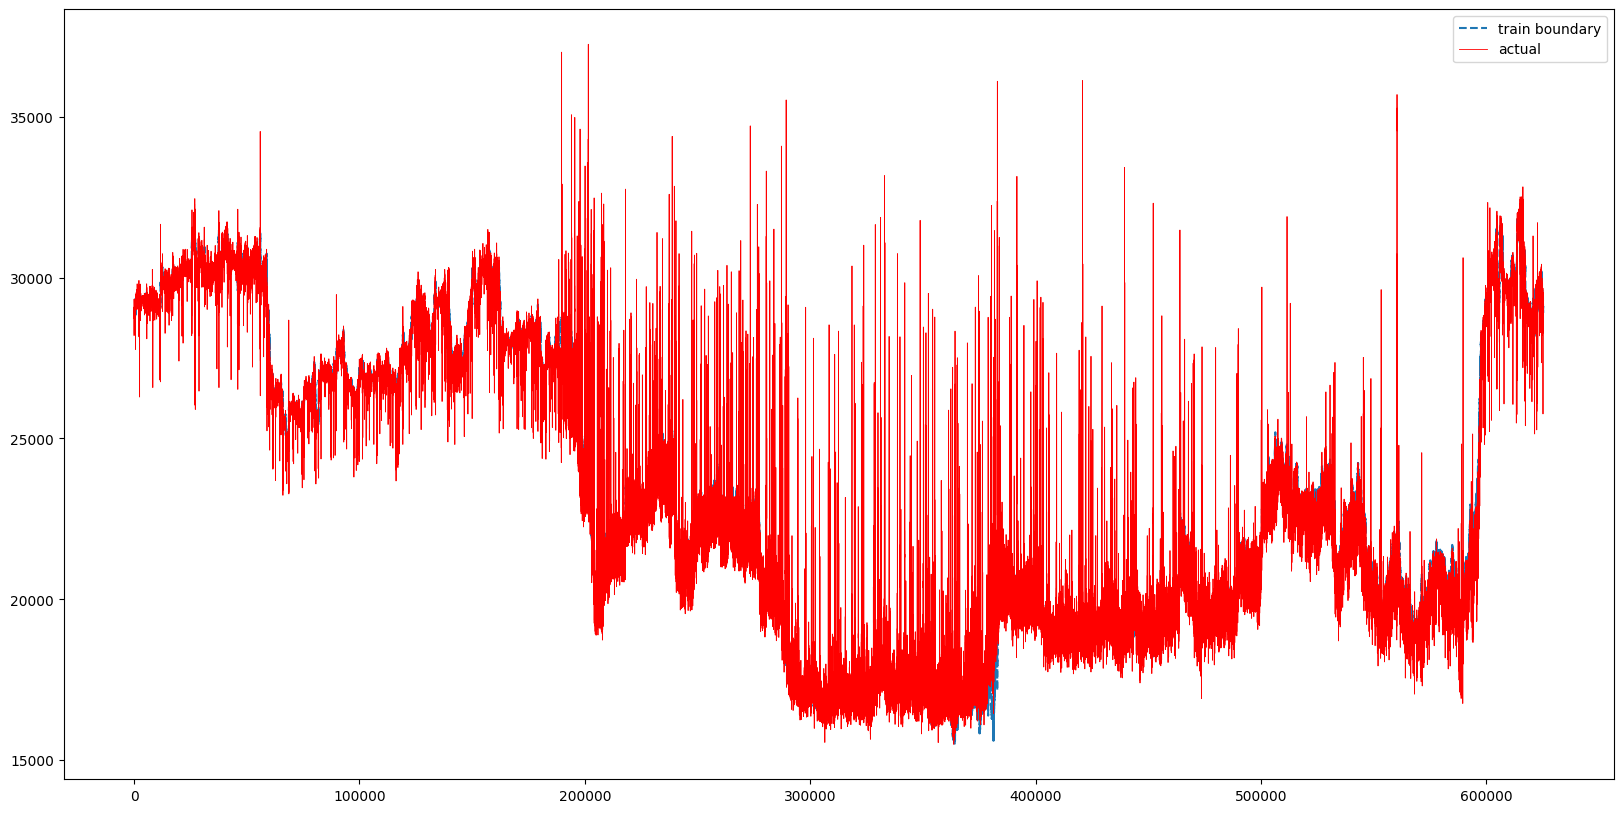

In [55]:
import matplotlib.pyplot as plt


plt.figure(figsize=(20,10))
# plt.plot(np.ones(100)*len(train),np.linspace(0,1,100),'--', linewidth=0.6)
plt.plot(rescaled_tsv_labels,'--')
plt.plot(rescaled_tsv_preds,'r', linewidth=0.6)
# plt.ylim(1200,2600)
plt.legend(['train boundary','actual','prediction'])
plt.show() 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


rescaled_actual = scaler.inverse_transform(val['close'][sequence_length:].values.reshape(-1,1))
rescaled_pred = scaler.inverse_transform(np.array(pred).reshape(-1,1))


plt.figure(figsize=(20,10))
plt.plot(np.ones(100)*len(train),np.linspace(0,1,100),'--', linewidth=0.6)
plt.plot(rescaled_actual,'--')
plt.plot(rescaled_pred,'b', linewidth=0.6)
plt.ylim(1200,2600)
plt.legend(['train boundary','actual','prediction'])
plt.show() 